# Build a Retrieval Augmented Generation With Llama and LangChain

Meta - Rag Course

One of the most powerful applications enabled by LLMs is sophisticated question-answering (Q&A) chatbots. These are applications that can answer questions about specific source information. These applications use a technique known as Retrieval Augmented Generation, or RAG.

In this course we will learn how to build a basic rag application and then progress to more complex levels.

In general, these are the course topics:
- Rag: Minimal Implementation
- Advanced Rag Techniques
- Agentic RGA

## Overview

A typical RAG application has two main components:

- Indexing: a pipeline for ingesting data from a source and indexing it.

- Retrieval and generation: the actual RAG chain, which takes the user query at run time and retrieves the relevant data from the index, then passes that to the model.


In this notebook, we'll create an application that answers questions about website content. The specific website we'll use is Lilian Weng's blog post [LLM Powered Autonomous Agents](https://lilianweng.github.io/posts/2023-06-23-agent/) which allows us to ask questions about the post's content.

## Setup

In [ ]:
%pip install -r requirements.txt

In [1]:
from dotenv import load_dotenv
load_dotenv(override=True) # Load environment variables from .env file

True

In [2]:
import getpass
import os

if not os.getenv("LANGSMITH_API_KEY"):
    os.environ["LANGSMITH_TRACING"] = "true"
    os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
    os.environ["LANGSMITH_PROJECT"] = "Llama-RAG"
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass('Enter the your LangSmith API key: ')

## Components

### Chat Model

In [3]:
from langchain_ollama import ChatOllama
from langchain_groq import ChatGroq
import getpass
import os

chat_model_type = "groq" # Change this to "ollama" if you want to use Ollama instead of Groq

if chat_model_type == "groq":
    if not os.environ.get("GROQ_API_KEY"):
        os.environ["GROQ_API_KEY"] = getpass.getpass("Enter API key for Groq: ")
    llm = ChatGroq(
        model="meta-llama/llama-4-scout-17b-16e-instruct",
        temperature=0
    )
elif chat_model_type == "ollama":
    llm = ChatOllama(
        model="llama3.2",
        temperature=0
    )

### Embedding Model

In [4]:
from langchain_openai import OpenAIEmbeddings
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

### Vector Store

In [5]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

## Indexing

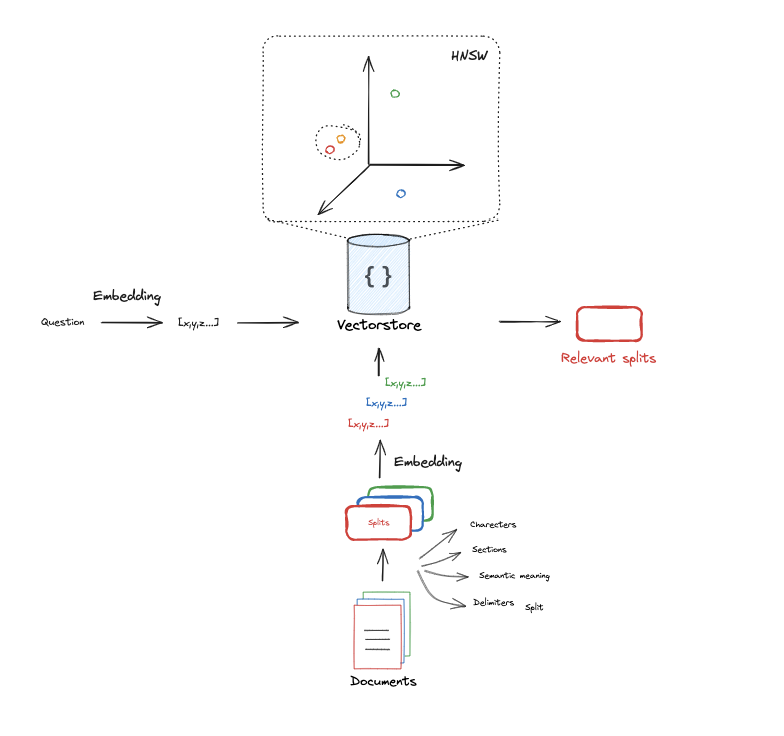

### example

In [ ]:
# Documents
question = "What kinds of pets do I like?"
document = "My favorite pet is a cat."

How to count tokens?

In [ ]:
import tiktoken

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

num_tokens_from_string(question, "cl100k_base")

In [ ]:
num_tokens_from_string(document, "cl100k_base")

In [ ]:
query_result = embeddings.embed_query(question)
document_result = embeddings.embed_query(document)
len(query_result)

In [ ]:
assert len(query_result) == len(document_result)

Cosine Similarity

In [ ]:
import numpy as np

def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

similarity = cosine_similarity(query_result, document_result)
print("Cosine Similarity:", similarity)

In [ ]:
question = "What kinds of pets do I like?"
document = "I've already been to London."

query_result = embeddings.embed_query(question)
document_result = embeddings.embed_query(document)

similarity = cosine_similarity(query_result, document_result)
print("Cosine Similarity:", similarity)

### Loading documents

We need to first load the blog post contents. We can use **DocumentLoaders** for this, which are objects that load in data from a source and return a list of **Document** objects.

LangChain implements a **Document abstraction**, which is intended to represent a unit of text and associated metadata. It has three attributes:

- page_content: a string representing the content;
- metadata: a dict containing arbitrary metadata;
- id: (optional) a string identifier for the document.

The metadata attribute can capture information about the source of the document, its relationship to other documents, and other information. Note that an individual Document object often represents a chunk of a larger document.

In this case we’ll use the **WebBaseLoader**, which uses urllib to load HTML from web URLs and **BeautifulSoup** to parse it to text. We can customize the HTML -> text parsing by passing in parameters into the BeautifulSoup parser via bs_kwargs (see BeautifulSoup docs). In this case only HTML tags with class “post-content”, “post-title”, or “post-header” are relevant, so we’ll remove all others.

In [6]:
# Load blog
import bs4
from langchain_community.document_loaders import WebBaseLoader
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [7]:
assert len(blog_docs) == 1
print(f"Total characters: {len(blog_docs[0].page_content)}")

Total characters: 43047


In [8]:
print(blog_docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


### Splitting documents

Our loaded document is over 43k characters which is too long to fit into the context window of many models. Even for those models that could fit the full post in their context window, models can struggle to find information in very long inputs.

To handle this we’ll split the Document into chunks for embedding and vector storage. This should help us retrieve only the most relevant parts of the blog post at run time.

This text splitter is the recommended one for generic text. It is parameterized by a list of characters. It tries to split on them in order until the chunks are small enough. The default list is ["\n\n", "\n", " ", ""]. This has the effect of trying to keep all paragraphs (and then sentences, and then words) together as long as possible, as those would generically seem to be the strongest semantically related pieces of text.

In [9]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
splits = text_splitter.split_documents(blog_docs)

print(f"Split blog post into {len(splits)} sub-documents.")

Split blog post into 63 sub-documents.


### Storing documents

Now we need to index our 63 text chunks so that we can search over them at runtime. So, our approach is to embed the contents of each document split and insert these embeddings into a vector store. Given an input query, we can then use **vector search** to retrieve relevant documents.

In [10]:
document_ids = vector_store.add_documents(documents=splits)

print(document_ids[:3])

['d0fb4a8c-0e5f-420c-a16c-68fc3a6217e3', '0aeb00c6-55b7-43a3-98a3-449fd4611f30', '1310683b-5536-4a05-bb06-9d82066b361e']


## Retrieval and Generation

Now let’s write the actual application logic. We want to create a simple application that takes a user question, searches for documents relevant to that question, passes the retrieved documents and initial question to a model, and returns an answer.

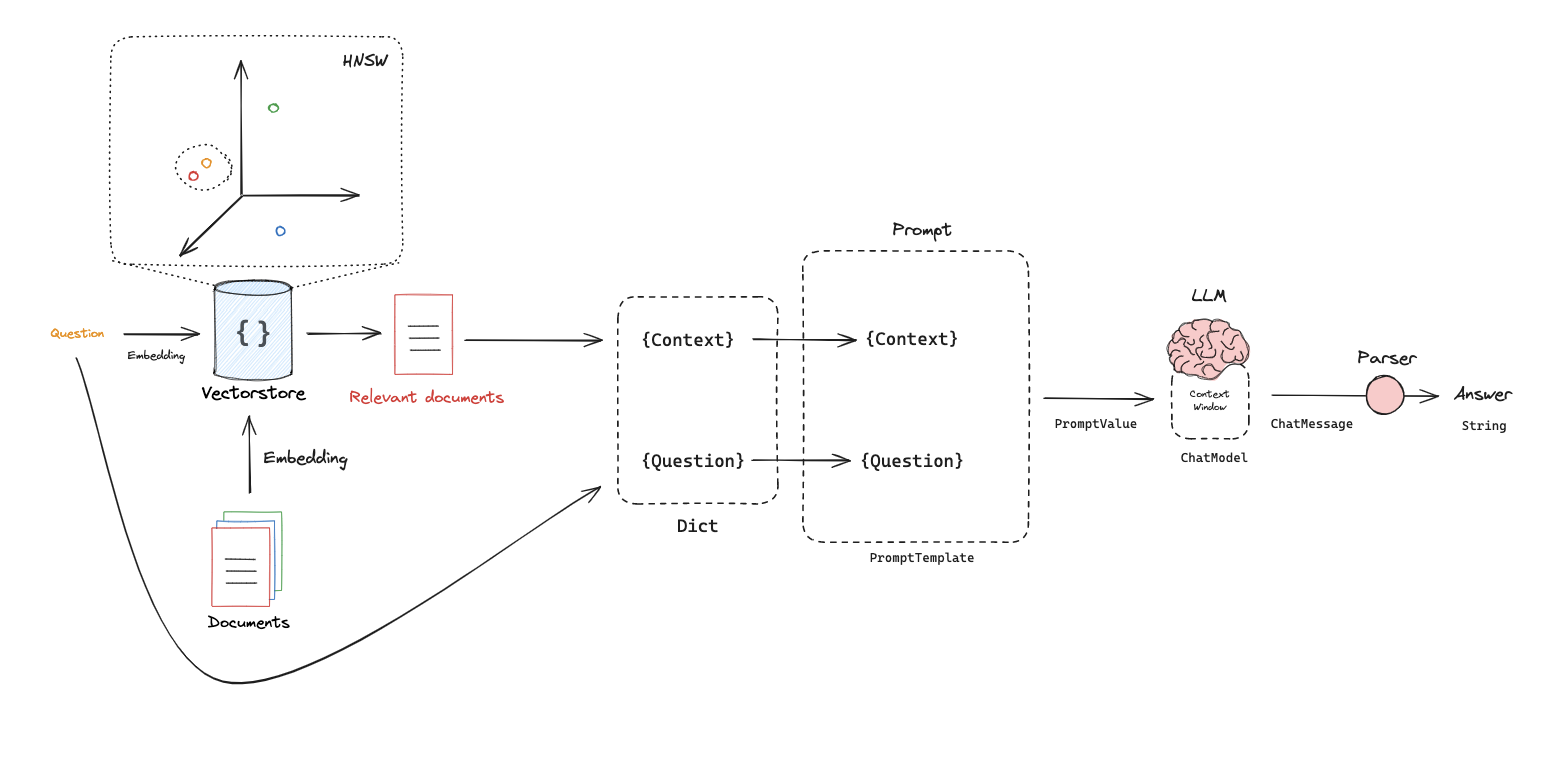

In [22]:
# Create a retriever from the vector store
retriever = vector_store.as_retriever(search_kwargs={"k": 1}, search_type="similarity")

In [23]:
docs = retriever.invoke("What is Task Decomposition?")

In [24]:
len(docs)

1

In [25]:
docs[0].page_content[:500]

'Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe'

In [26]:
from langchain.prompts import ChatPromptTemplate

# Prompt
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='Answer the question based only on the following context:\n{context}\n\nQuestion: {question}\n'), additional_kwargs={})])

In [27]:
from pprint import pprint
example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

pprint(example_messages[0].content)

('Answer the question based only on the following context:\n'
 '(context goes here)\n'
 '\n'
 'Question: (question goes here)\n')


In [28]:
# Chain
chain = prompt | llm

In [29]:
def format_docs(docs: list):
    return "\n\n".join([doc.page_content for doc in docs])

In [30]:
# Run
chain.invoke({"context": format_docs(docs), "question": "What is Task Decomposition?"})

AIMessage(content='Based on the provided context, task decomposition can be done in the following ways:\n\n1. By LLM with simple prompting (e.g., "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?").\n2. By using task-specific instructions (e.g., "Write a story outline." for writing a novel).\n3. With human inputs.\n\nNo explicit definition of task decomposition is provided, but it appears to involve breaking down a task into smaller subgoals or steps.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 100, 'prompt_tokens': 239, 'total_tokens': 339, 'completion_time': 0.23055224, 'prompt_time': 0.009184869, 'queue_time': 0.26945788600000004, 'total_time': 0.239737109}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_37da608fc1', 'finish_reason': 'stop', 'logprobs': None}, id='run--44ae88f5-c0f7-4254-9a73-6a3fe7abf4e0-0', usage_metadata={'input_tokens': 239, 'output_tokens': 100, 'total_tokens': 339})

Rag chain

In [31]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

rag_chain.invoke("What is Task Decomposition?")

'Based on the provided context, task decomposition can be done in the following ways:\n\n1. By LLM with simple prompting (e.g., "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?").\n2. By using task-specific instructions (e.g., "Write a story outline." for writing a novel).\n3. With human inputs.\n\nNo explicit definition of task decomposition is provided, but it appears to involve breaking down a task into smaller subgoals or steps.'

### Rag pipeline with LangGraph

First we’ll use a prompt for RAG that is checked into the LangChain prompt hub [here](https://smith.langchain.com/hub/rlm/rag-prompt?_gl=1*1w7xf4o*_gcl_au*MjA2Mzc2MzA5MS4xNzUxNDg5Mjk5*_ga*ODQ1MzM2ODY1LjE3NTE0ODkzMDA.*_ga_47WX3HKKY2*czE3NTI4NTcyOTUkbzkkZzEkdDE3NTI4NjA1NzkkajYwJGwwJGgw).

In [11]:
from langchain import hub

# N.B. for non-US LangSmith endpoints, you may need to specify
# api_url="https://api.smith.langchain.com" in hub.pull.
prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

In [12]:
assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


We'll use **LangGraph** to tie together the retrieval and generation steps into a single application. This will bring a number of benefits:

- We can define our application logic once and automatically support multiple invocation modes, including streaming, async, and batched calls.
- We can easily add key features to our application, including persistence and human-in-the-loop approval, with minimal code changes.
- LangSmith will automatically trace the steps of our application together.

To use LangGraph, we need to define three things:

1. The state of our application;
2. The nodes of our application (i.e., application steps);
3. The "control flow" of our application (e.g., the ordering of the steps).

**State**:
The state of our application controls what data is input to the application, transferred between steps, and output by the application. It is typically a TypedDict, but can also be a Pydantic BaseModel.

For a simple RAG application, we can just keep track of the input question, retrieved context, and generated answer:

In [13]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

**Nodes** (application steps):
Let's start with a simple sequence of two steps: retrieval and generation.

In [14]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

Our retrieval step simply runs a similarity search using the input question, and the generation step formats the retrieved context and original question into a prompt for the chat model.

**Control flow**:

Finally, we compile our application into a single graph object. In this case, we are just connecting the retrieval and generation steps into a single sequence.

In [15]:
from langgraph.graph import START, END, StateGraph

graph_builder = StateGraph(State)

graph_builder.add_edge(START, "retrieve")
graph_builder.add_node("retrieve", retrieve)

graph_builder.add_edge("retrieve", "generate")
graph_builder.add_node("generate", generate)

graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

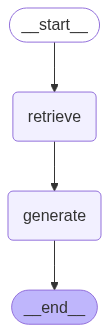

In [16]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

Invoke:

In [17]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

Context: [Document(id='794fd6ca-f5f7-4a63-bf5b-f1bdb112395b', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool,

In [18]:
result

{'question': 'What is Task Decomposition?',
 'context': [Document(id='794fd6ca-f5f7-4a63-bf5b-f1bdb112395b', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the p

Stream steps:

In [19]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='794fd6ca-f5f7-4a63-bf5b-f1bdb112395b', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to a

Stream tokens:

In [20]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

|Task| Decomposition| is| a| technique| used| to| break| down| complex| tasks| into| smaller|,| more| manageable| steps|.| This| can| be| achieved| through| various| methods|,| including| prompting| with| simple| questions|,| using| task|-specific| instructions|,| or| incorporating| human| inputs|.| It| enables| models| to| plan| ahead| and| tackle| complicated| tasks| by| decom|posing| them| into| multiple| simpler| steps|.||

Customizing the prompt:

In [21]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)
custom_rag_prompt

PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='Use the following pieces of context to answer the question at the end.\nIf you don\'t know the answer, just say that you don\'t know, don\'t try to make up an answer.\nUse three sentences maximum and keep the answer as concise as possible.\nAlways say "thanks for asking!" at the end of the answer.\n\n{context}\n\nQuestion: {question}\n\nHelpful Answer:')

In [32]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

# Define prompt for question-answering
# N.B. for non-US LangSmith endpoints, you may need to specify
# api_url="https://api.smith.langchain.com" in hub.pull.
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [36]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"question": input_message},
    stream_mode="values",
):
    print(step)
    if step.get('answer'):
        print()
        print(f"Answer: {step['answer']}")

{'question': 'What is Task Decomposition?'}
{'question': 'What is Task Decomposition?', 'context': [Document(id='794fd6ca-f5f7-4a63-bf5b-f1bdb112395b', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan bac

## Query analysis

So far, we are executing the retrieval using the raw input query. However, there are some advantages to allowing a model to generate the query for retrieval purposes. For example:

In addition to semantic search, we can build in structured filters (e.g., "Find documents since the year 2020.");
The model can rewrite user queries, which may be multifaceted or include irrelevant language, into more effective search queries.

We will add some (contrived) sections to the document which we can filter on later.

In [37]:
total_documents = len(splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'section': 'beginning'}

In [38]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

Let's next define a schema for our search query. We will use structured output for this purpose. Here we define a query as containing a string query and a document section (either "beginning", "middle", or "end"), but this can be defined however you like.

In [39]:
from typing import Literal

from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

Finally, we add a step to our LangGraph application to generate a query from the user's raw input:

In [ ]:
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"], # Filter by section
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

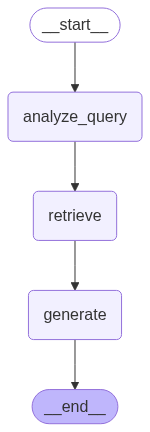

In [41]:
display(Image(graph.get_graph().draw_mermaid_png()))

Test:

In [42]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task Decomposition end of post', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='ec38a584-5043-43f8-a314-e649cb5094ec', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'section': 'end'}, page_content='"content": "Please now remember the steps:\\n\\nThink step by step and reason yourself to the right decisions to make sure we get it right.\\nFirst lay out the names of the core classes, functions, methods that will be necessary, As well as a quick comment on their purpose.\\n\\nThen you will output the content of each file including ALL code.\\nEach file must strictly follow a markdown code block format, where the following tokens must be replaced such that\\nFILENAME is the lowercase file name including the file extension,\\nLANG is the markup code block language for the code\'s language, and CODE is the code:\\n\\nFILENAME\\n```LANG\\nCODE\\n```\\n\\nPlease note that the code should be full